<a href="https://colab.research.google.com/github/lahirumanulanka/ai-notebooks/blob/main/02_fully_connected_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sumani
# https://www.linkedin.com/in/sumanaruban/
# https://github.com/Sumanaruban
# 29-7-2024

# Fully Connected Neural Network for MNIST Classification using PyTorch

In this notebook, we will walk through the process of building, training, and evaluating a fully connected neural network for classifying handwritten digits from the MNIST dataset using PyTorch. We'll cover data loading and preprocessing, model definition, training, evaluation, and visualization of the results.

## Import the required packages and modules

We use:

- torch for tensor operations and neural network building.

- torch.nn and torch.nn.functional for model architecture and activations.

- torchvision to conveniently download and process common vision datasets like MNIST.

- transforms for converting image data into PyTorch tensors and applying preprocessing steps.


In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Step 1: Data Loading and Preprocessing

We'll start by defining the transformations to apply to the images and loading the MNIST dataset.

#### MNIST Dataset

The MNIST (Modified National Institute of Standards and Technology) dataset is a large database of handwritten digits that is commonly used for training various image processing systems. The dataset contains 70,000 images of handwritten digits (0-9) with 60,000 images in the training set and 10,000 images in the test set. Each image is a 28x28 grayscale image, meaning each pixel value ranges from 0 (black) to 255 (white). The dataset is well-suited for training and testing machine learning models in image recognition tasks, and it has become a standard benchmark for evaluating algorithms.



#### torch.utils.data.DataLoader

torch.utils.data.DataLoader is a utility in PyTorch that provides an efficient way to load and preprocess data. It allows for easy batching, shuffling, and parallel data loading using multiple workers. Key features include:

1. `Batching`: Automatically groups data into batches.

2. `Shuffling`: Randomizes the order of data samples, which is important for training neural networks.

3. `Parallel Loading`: Utilizes multiple CPU cores to load data in parallel, reducing the time spent on data loading.

DataLoader is essential for handling large datasets and ensuring efficient data feeding during the training and evaluation of models.

In [2]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the pixel values with mean and std
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 35.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.82MB/s]


# Step 2: Exploratory Data Analysis (EDA)

Let's visualize some sample images from the MNIST dataset.

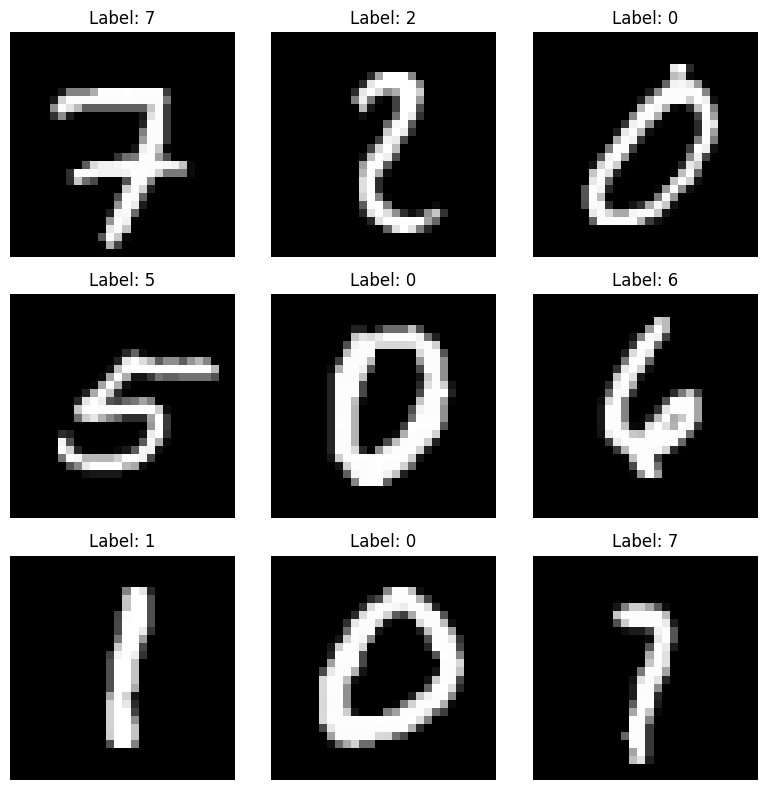

In [3]:
# Visualize some sample images
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.imshow(example_data[i][0], cmap='gray')
    ax.set_title(f'Label: {example_targets[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Step 3: Define the Neural Network Model

We will define a simple fully connected neural network with two layers.


#### torch.nn Module

The `torch.nn` module in PyTorch provides a wide range of classes and functions to help you build neural networks. It includes pre-defined layers, activation functions, loss functions, and utilities that can be used to define and train neural networks. Some key components include:

1. `Layers`: nn.Linear, nn.Conv2d, nn.RNN, etc., to define various types of neural network layers.

2. `Activations`: nn.ReLU, nn.Sigmoid, nn.Tanh, etc., to introduce non-linearities in the network.

3. `Loss Functions`: nn.CrossEntropyLoss, nn.MSELoss, etc., to calculate the loss during training.

4. `Container Modules`: nn.Sequential, nn.ModuleList, nn.ModuleDict, to organize and manage layers.

Overall, torch.nn provides the building blocks for creating and training neural networks in PyTorch.

In [4]:
# Define the neural network model
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()

        # First Layer
        self.layer_1 = nn.Linear(28*28, 512)
        self.activation_1 = nn.ReLU() # ReLU activation

        # Second layer
        self.layer_2 = nn.Linear(512, 10)

    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 28*28)

        # Calling the first layer
        x = self.layer_1(x)
        x = self.activation_1(x)

        # Calling the second layer
        x = self.layer_2(x)  # Output layer
        return x

# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConnectedNet().to(device)
print(model)

FullyConnectedNet(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (activation_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=10, bias=True)
)


### 🔍 Explanation:

Input: Each MNIST image is 28×28, flattened into a vector of 784 features.

Layers:

- fc1: Fully connected layer with 128 neurons

- fc2: Fully connected layer with 64 neurons

- fc3: Output layer with 10 neurons for each digit class

Activations: ReLU is used after fc1 and fc2.

No Softmax in last layer: nn.CrossEntropyLoss expects raw logits and internally applies LogSoftmax.

In [5]:
from torchsummary import summary

summary(model, input_size=(1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [8]:
#install torchviz
#!pip install torchviz

from torchviz import make_dot
import torch

x = torch.randn(1, 784)
y = model(x)

make_dot(y, params=dict(model.named_parameters())).render("nn_mnist_graph", format="png")

'nn_mnist_graph.png'

# Step 4: Define the Loss Function and Optimizer

We'll use cross-entropy loss and stochastic gradient descent (SGD) optimizer.

#### CrossEntropyLoss

CrossEntropyLoss is a commonly used loss function for classification problems in neural networks. It combines LogSoftmax and NLLLoss (negative log-likelihood loss) in a single class. CrossEntropyLoss is particularly useful for multi-class classification tasks.

#### Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) is an optimization algorithm used to minimize the loss function during the training of a machine learning model. Unlike traditional gradient descent, which computes the gradient of the loss function using the entire training dataset, SGD updates the model parameters using only a single training example or a small batch of examples at each iteration. This makes SGD more efficient and able to handle large datasets. Key features of SGD include:

* Efficiency: Faster convergence on large datasets.

* Stochastic Nature: Introduces noise in the parameter updates, which can help in escaping local minima.

* Adjustable Learning Rate: Allows tuning of the learning rate to control the step size of parameter updates.



In [9]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss() # loss function – CrossEntropy is commonly used for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.01) # Adam optimizer updates model weights during training

# Step 5: Training the Model

Let's define the training loop.

This is the core training loop:

- Pass inputs through the model.

- Compute the loss between predicted outputs and true labels.

- Backpropagate the loss to compute gradients.

- Update weights using optimizer.

This is repeated for each epoch (full pass over training data).

In [10]:
# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

running_loss = 0.0
running_acc = 0.0

# Define the training loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    global running_loss
    global running_acc
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i + 1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

# Track training loss and accuracy
train_losses = []
train_accuracies = []

# Train the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_acc / len(train_loader))


Epoch 1, Batch 200, Loss: 1.0950, Accuracy: 0.7681
Epoch 1, Batch 400, Loss: 0.4895, Accuracy: 0.8753
Epoch 1, Batch 600, Loss: 0.4048, Accuracy: 0.8880
Epoch 1, Batch 800, Loss: 0.3559, Accuracy: 0.9001
Epoch 2, Batch 200, Loss: 0.5399, Accuracy: 0.9113
Epoch 2, Batch 400, Loss: 0.2913, Accuracy: 0.9159
Epoch 2, Batch 600, Loss: 0.2857, Accuracy: 0.9186
Epoch 2, Batch 800, Loss: 0.2786, Accuracy: 0.9197
Epoch 3, Batch 200, Loss: 0.4393, Accuracy: 0.9284
Epoch 3, Batch 400, Loss: 0.2496, Accuracy: 0.9298
Epoch 3, Batch 600, Loss: 0.2359, Accuracy: 0.9327
Epoch 3, Batch 800, Loss: 0.2319, Accuracy: 0.9349
Epoch 4, Batch 200, Loss: 0.3734, Accuracy: 0.9384
Epoch 4, Batch 400, Loss: 0.2105, Accuracy: 0.9426
Epoch 4, Batch 600, Loss: 0.2078, Accuracy: 0.9418
Epoch 4, Batch 800, Loss: 0.2042, Accuracy: 0.9420
Epoch 5, Batch 200, Loss: 0.3259, Accuracy: 0.9459
Epoch 5, Batch 400, Loss: 0.1842, Accuracy: 0.9498
Epoch 5, Batch 600, Loss: 0.1784, Accuracy: 0.9477
Epoch 5, Batch 800, Loss: 0.185

# Step 6: Evaluating the Model

We'll define a function to evaluate the model on the test dataset.

Explanation:

- torch.no_grad() disables gradient tracking (for faster inference).

- outputs.argmax(dim=1).cpu().numpy() returns the predicted class.

- Compares predictions with true labels to calculate accuracy.

In [11]:
# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}')
    return all_preds, all_labels

# Test the model
all_preds, all_labels = test(model, device, test_loader, criterion)


Test Loss: 0.1175, Test Accuracy: 0.9655


# Step 7: Visualizing Training Progress

Let's plot the training loss and accuracy over the epochs.

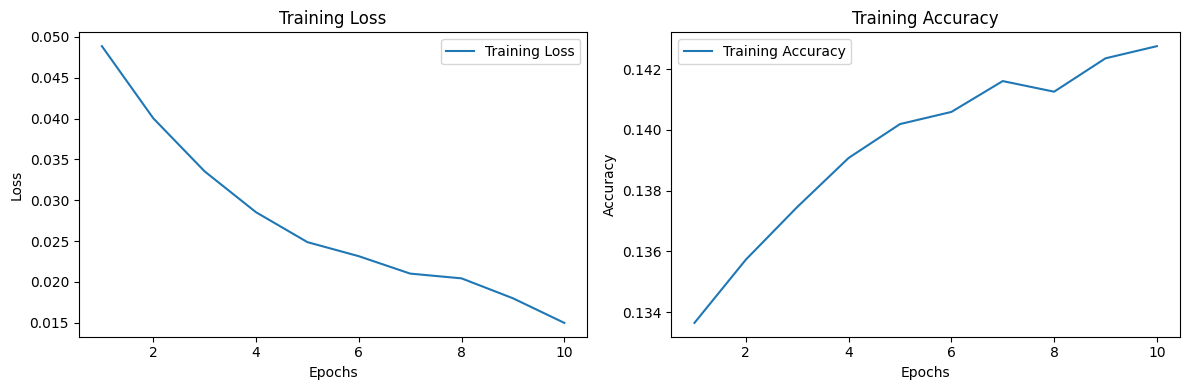

In [12]:
# Plot training loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 8: Confusion Matrix

We'll plot the confusion matrix to see how well the model is performing across different classes.

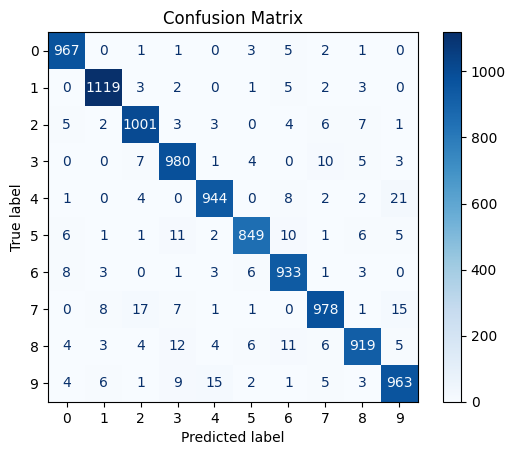

In [13]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Step 9: Visualizing Predictions

Finally, let's visualize some sample predictions from the model.

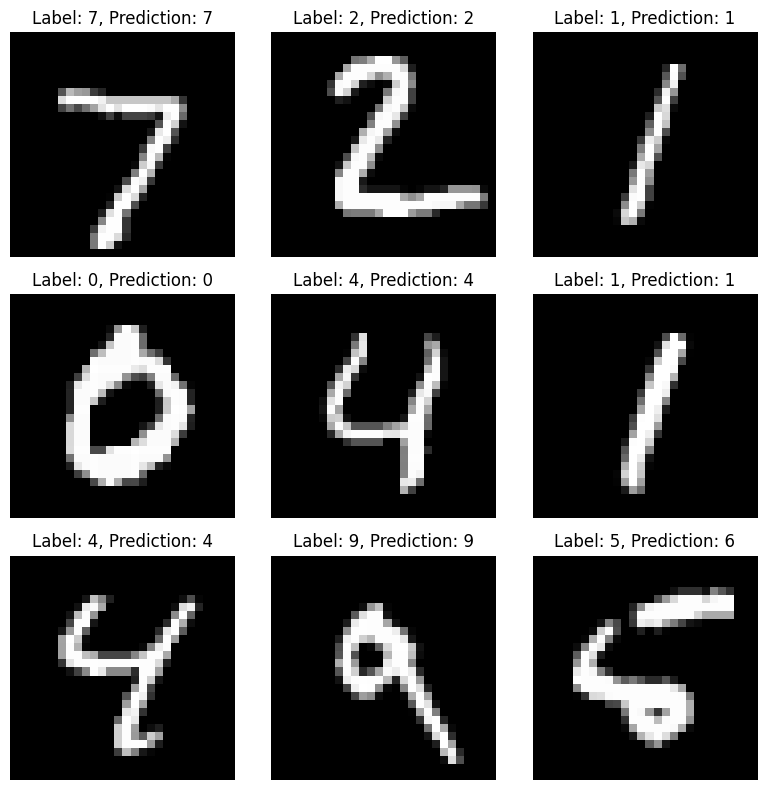

In [14]:
# Visualize some sample images and predictions
samples, labels = next(iter(test_loader))
samples, labels = samples.to(device), labels.to(device)
outputs = model(samples)
_, preds = torch.max(outputs, 1)
samples = samples.cpu().numpy()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i]}, Prediction: {preds[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


Let's display some examples where the model made incorrect predictions.

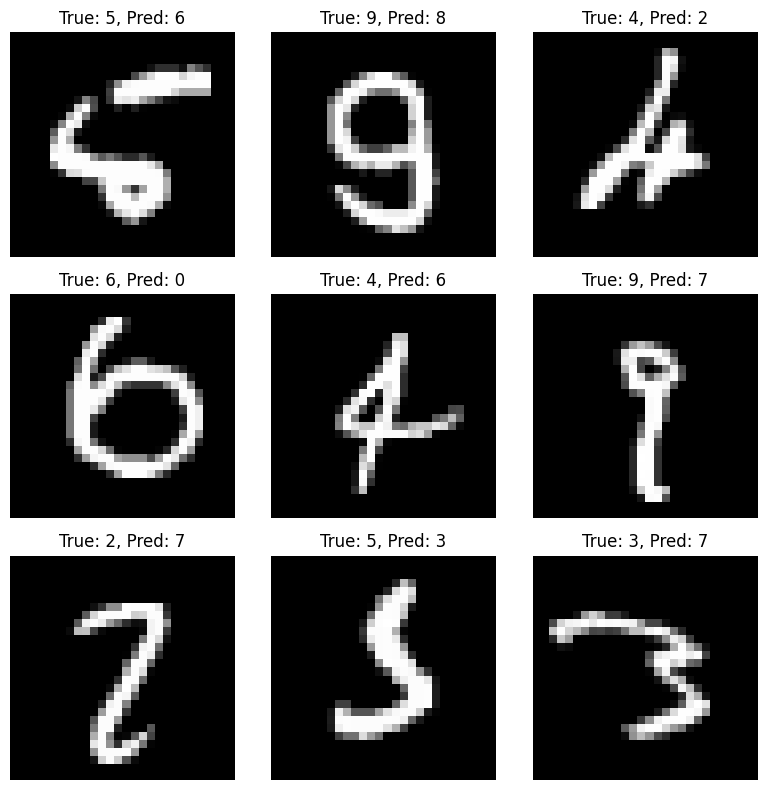

In [15]:
# Visualize incorrect predictions
incorrect = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    idx = incorrect[i]
    ax.imshow(test_loader.dataset[idx][0][0], cmap='gray')
    ax.set_title(f'True: {all_labels[idx]}, Pred: {all_preds[idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


# 10. Conclusion

This notebook builds a simple yet effective neural network to classify handwritten digits. It demonstrates:

- How to structure a feedforward network in PyTorch

- Data preprocessing using torchvision

- Model Definition

- Training with CrossEntropyLoss and Adam

- Evaluating model performance using accuracy

- Visualization of results

This forms the foundation for deeper models like CNNs and RNNs, which you will encounter later in the course.

This provides a good foundation for understanding the process of developing neural network models for image classification tasks.